In [41]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [42]:
file_path = 'Merged_Ni_lessthan15km.csv'

df = pd.read_csv(file_path, index_col=0)
df.head(3)

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
0,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46661,"(-17.34893, 128.022095)",S0001442,-17.234642,128.032146,12.693593881734987 km
1,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46662,"(-17.31078, 128.023499)",S0002890,-17.234642,128.032146,8.476376684524638 km
2,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46663,"(-17.3526, 128.027695)",S0019720,-17.234642,128.032146,13.063277176872425 km


In [43]:
df.shape

(150625, 19)

In [44]:
df[df['Co'] == df['Co'].max()]

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
15478,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73190,"(-26.107121, 127.696899)",S0019102,-26.061367,127.580028,12.744010894761297 km
15479,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73191,"(-26.107121, 127.696899)",S0224398,-26.061367,127.580028,12.744010894761297 km


In [45]:
df_unique = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'lat', 'long', 
                     'minedex_coords', 'minedex_site',
                    'distance'])

df_unique = df_unique.drop_duplicates()

In [5]:
print(f"Amount of Duplicate rows: {df.shape[0] - df_unique.shape[0]}")

Amount of Duplicate rows: 127392


In [211]:
df_unique.shape

(23233, 12)

### WAMEX data

 ·      Cobalt associated with nickel (and copper) in so-called orthomagmatic (igneous) mafic to ultramafic volcanic (komatiite)-hosted and intrusion-hosted deposits
 
 
 Cobalt is a chemical element with the symbol Co and atomic number 27. Like nickel, cobalt is found in the Earth's crust only in a chemically combined form, save for small deposits found in alloys of natural meteoric iron. The free element, produced by reductive smelting, is a hard, lustrous, silver-gray metal. Wikipedia
Symbol: Co <br>
Electron configuration: [Ar] 3d74s2 <br>
Atomic number: 27 <br>
Atomic mass: 58.933195 u <br>
Melting point: 1,495 °C <br>
Discovered: 1735 <br>
Discoverer: Georg Brandt <br>

### Nickel and Iron

In [46]:
# most common pair in MINEDEX data.
abdundant_minerals = ['Nickel', 'Iron'] #'Sulfur', 'Palladium','Platinum',
critical_mineral = ['Cobalt']

full_to_atomic = {
    "Copper": "Cu",
    "Cobalt": "Co",
    "Nickel": "Ni",
    "Iron": "Fe",
    "Sulfur": "S",
    "Palladium": "Pd",
    "Platinum": "Pt",
    "Gold": "Au",
    "Silver": "Ag"
}


In [47]:
def get_clean_mineral_col(df):
    new_cols = []
    for col in df.columns: 
        if "ppm" in col:
            new_cols.append(col.split('_')[0])
        else:
            new_cols.append(col)
            
    return new_cols

df_unique.columns = get_clean_mineral_col(df_unique)

In [75]:
df_unique.head(2)

,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,wamex_lat,wamex_lon
0,56.0,420.0,9.0,14.0,0.010,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146
5,31.0,195.0,6.0,10.0,0.007,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146


In [48]:
minerals = abdundant_minerals + critical_mineral

minerals_atomic = [full_to_atomic[mineral] for mineral in minerals]
minerals_atomic

['Ni', 'Fe', 'Co']

In [49]:
input_cols = ['wamex_lat', 'wamex_lon'] + minerals_atomic

In [50]:
df_inputs = df_unique[input_cols]
df_inputs.head(2)

,wamex_lat,wamex_lon,Ni,Fe,Co
0,-17.234642,128.032146,56.0,NaN,9.0
5,-17.234642,128.032146,31.0,NaN,6.0


In [51]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
def abs_halve_neg_val(val):
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

def clean_assays(df):
    df = df.applymap(replace_neg9999)
    df = df.applymap(abs_halve_neg_val)
    df = df[df['Ni'] < 300000]
    indexs_0 = df[df.values == 0].index
    df = df.drop(index=indexs_0)
    
    return df

def abundant_ratio(row, abundant_mineral):
    return row / row[abundant_mineral]

In [52]:
df_minerals = df_inputs.drop(columns=['wamex_lat', 'wamex_lon'])

df_inputs.loc[:, df_minerals.columns] = clean_assays(df_inputs.loc[:,df_minerals.columns])
df_inputs.shape

C:\Users\missc\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\missc\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


(23233, 5)

## `drop_na`

In [53]:
df_inputs = df_inputs.dropna()
df_inputs = df_inputs.drop_duplicates()
df_inputs.shape

(14261, 5)

<AxesSubplot:ylabel='Frequency'>

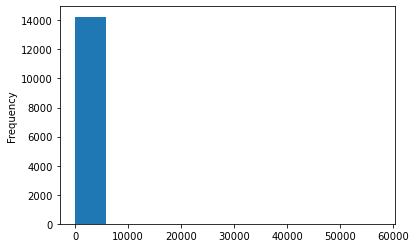

In [54]:
df_inputs['Co'].plot(kind='hist')

<AxesSubplot:>

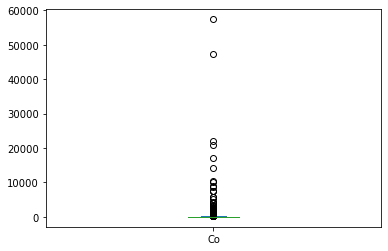

In [55]:
df_inputs['Co'].plot(kind='box')

In [56]:
#remove 2 large outliers 
df_inputs = df_inputs[df_inputs['Co'] < 40000]

<AxesSubplot:>

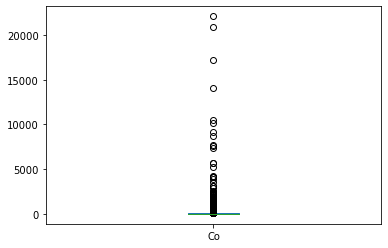

In [230]:
df_inputs['Co'].plot(kind='box')

In [231]:
df_inputs['Co'].describe()

count    14259.000000
mean        75.983857
std        415.441102
min          0.000500
25%         10.000000
50%         25.000000
75%         64.000000
max      22106.000000
Name: Co, dtype: float64

### LARGE Colbalt deposits

In [15]:
df_inputs[df_inputs['Co'] > 10000]

,wamex_lat,wamex_lon,Ni,Fe,Co
3342,-32.094878,121.651236,6450.0,9266.7,10476.0
15446,-26.060096,127.578510,14811.0,5090.0,10122.0
15452,-26.060924,127.579434,32363.0,6700.0,22106.0
15454,-26.062044,127.580593,32734.0,3440.0,20913.0
15472,-26.061490,127.579983,23560.0,8730.0,14119.0
52865,-32.096211,121.651299,10782.0,12120.0,17180.0


### Apply Ratio Transform

In [57]:
df_inputs.loc[:, df_minerals.columns] = df_inputs.loc[:, df_minerals.columns].apply(
                                                            abundant_ratio, abundant_mineral='Ni',
                                                            axis=1)

In [58]:
df_inputs['Co'].describe()

count    14259.000000
mean        20.274015
std        976.536230
min          0.000030
25%          0.080036
50%          0.217822
75%          0.382353
max      80000.000000
Name: Co, dtype: float64

### Log Transform

In [18]:
import numpy as np

<AxesSubplot:ylabel='Frequency'>

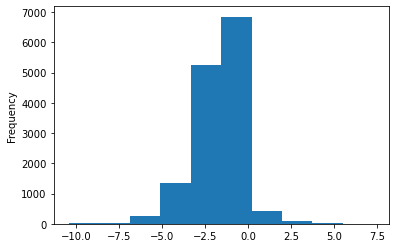

In [59]:
np.log(df_inputs[df_inputs['Co'] < 5000]['Co']).plot(kind='hist')

In [60]:
df_inputs.loc[:, df_minerals.columns] = df_inputs.loc[:,df_minerals.columns].apply(np.log, axis=1)

### Independent Variables

In [21]:
from sklearn.preprocessing import StandardScaler

## Plotting First 100 Observations

<AxesSubplot:>

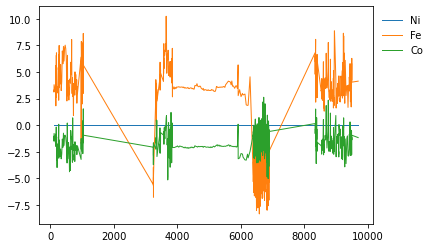

In [176]:
df_inputs[minerals_atomic][:1000].plot()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Drop `Ni`

In [61]:
df_inputs = df_inputs.drop(columns=['Ni'])

### Split Indepdent from dependents

In [62]:
y = df_inputs['Co']
X = df_inputs.drop(columns=['Co'])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()

lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

from sklearn.metrics import mean_squared_error

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 1.273370883235352
Test MSE: 1.3383296003426177


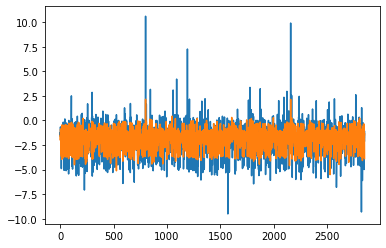

In [241]:
plt.plot(range(0, len(test_preds)), y_test, test_preds)

In [64]:
pd.Series(X_train.columns, lr.coef_).sort_values(ascending=False)

-0.199844    wamex_lon
 0.019474    wamex_lat
 0.247763           Fe
dtype: object

### Predict from MINDEX data

In [65]:
pred_set = pd.read_csv('./ni_fe_prediction_set.csv')
pred_set.head()

,Unnamed: 0,Nickel,Iron,Latitude,Longitude
0,S0001174,6000.0,79300.0,-33.633382,120.374303
1,S0004371,9900.0,325000.0,-29.125713,122.999515
2,S0004371,9900.0,325000.0,-29.125713,122.999515
3,S0005631,6200.0,108000.0,-33.666733,120.400034
4,S0006586,5500.0,113000.0,-33.592899,120.280502


In [66]:
# save original nickel before transform.
orig_ni = pred_set['Nickel']

In [67]:
pred_set = pred_set.rename(columns={
    "Nickel": "Ni",
    "Iron": "Fe",
    "Latitude": "wamex_lat",
    "Longitude": "wamex_lon",
    "Unnamed: 0": 'site_code'
})

In [68]:
df_minerals = pred_set.drop(columns=['wamex_lat', 'wamex_lon', 'site_code'])




pred_set.loc[:, df_minerals.columns] = pred_set.loc[:, df_minerals.columns].apply(
                                                            abundant_ratio, abundant_mineral='Ni',
                                                            axis=1)

pred_set = pred_set.drop(columns=['Ni'])

In [69]:
pred_set['Fe'] = pred_set['Fe'].apply(np.log, axis=1)

#### Template of what X should look like

In [70]:
X.head(2)

,wamex_lat,wamex_lon,Fe
106,-17.742535,127.903385,3.297989
109,-17.737059,127.903390,3.120324


In [71]:
X.columns

Index(['wamex_lat', 'wamex_lon', 'Fe'], dtype='object')

In [72]:
pred_X = pred_set[X.columns]

In [73]:
pred_set['Co_pred'] = lr.predict(pred_X)

In [74]:
pred_set.head(2)

,site_code,Fe,wamex_lat,wamex_lon,Co_pred
0,S0001174,2.581479,-33.633382,120.374303,-1.955282
1,S0004371,3.491290,-29.125713,122.999515,-2.166715


#### Invert preds

In [75]:
pred_set['Co_pred'] = np.exp(pred_set['Co_pred'])  * orig_ni

In [76]:
pred_set.head()

,site_code,Fe,wamex_lat,wamex_lon,Co_pred
0,S0001174,2.581479,-33.633382,120.374303,849.147742
1,S0004371,3.491290,-29.125713,122.999515,1134.078137
2,S0004371,3.491290,-29.125713,122.999515,1134.078137
3,S0005631,2.857582,-33.666733,120.400034,934.152261
4,S0006586,3.022640,-33.592899,120.280502,885.417178


In [77]:
minedex = pd.read_csv('Transformed_Minedex_data.csv')

In [78]:
pred_sites = pred_set.site_code.to_list()

In [79]:
minedex = minedex[minedex['SiteCode'].isin(pred_sites)]

minedex_co = minedex[minedex['CommodityName'] == 'Cobalt']

minedex_co_uniq = minedex_co[['SiteCode', 'CommodityName']].drop_duplicates().index

In [80]:
minedex_co_uniq = minedex_co[minedex_co.index.isin(minedex_co_uniq)]
minedex_co_uniq

,SiteCode,StartDate,EndDate,Tonnage (Mt),Grade,GradeUnit,CommodityName,ContainedMetal,ContainedMetalUnit,CutOffGrade,TargetCommodityGroup,quantity(tonne),ppm
5649,S0001174,31/12/2017,NaN,11.100000,0.020,percent,Cobalt,2220.00000,tonnes,NaN,NICKEL,2220.00000,200.0
8633,S0004371,01/10/2013,30/12/2018,9.780000,0.100,percent,Cobalt,9780.00000,tonnes,NaN,NICKEL,9780.00000,1000.0
8996,S0005631,31/12/2017,NaN,24.300000,0.030,percent,Cobalt,7290.00000,tonnes,NaN,NICKEL,7290.00000,300.0
9205,S0006586,31/12/2012,NaN,31.400000,0.020,percent,Cobalt,6280.00000,tonnes,NaN,NICKEL,6280.00000,200.0
9271,S0006685,31/12/2012,NaN,63.100000,0.030,percent,Cobalt,18930.00000,tonnes,NaN,NICKEL,18930.00000,300.0
9378,S0016710,24/09/2013,NaN,4.338000,0.084,percent,Cobalt,3643.92000,tonnes,NaN,NICKEL,3643.92000,840.0
9385,S0016719,31/03/2001,NaN,5.390000,0.084,percent,Cobalt,4527.60000,tonnes,NaN,NICKEL,4527.60000,840.0
9559,S0018838,31/12/2017,NaN,81.800000,0.030,percent,Cobalt,24540.00000,tonnes,NaN,NICKEL,24540.00000,300.0
9628,S0018919,26/02/2014,30/12/2018,0.840000,0.090,percent,Cobalt,756.00000,tonnes,NaN,NICKEL,756.00000,900.0
10321,S0020571,31/10/2000,NaN,4.650000,0.069,percent,Cobalt,3208.50000,tonnes,NaN,NICKEL,3208.50000,690.0


In [81]:
cross_ref = pred_set[['site_code', 'Co_pred']].merge(minedex_co_uniq[['SiteCode', 'ppm']],
                                        left_on='site_code', 
                                        right_on='SiteCode')

cross_ref = cross_ref.rename(columns={
    "ppm": "Co_true"
})

cross_ref.drop(columns=['SiteCode'])

,site_code,Co_pred,Co_true
0,S0001174,849.147742,200.0
1,S0004371,1134.078137,1000.0
2,S0004371,1134.078137,1000.0
3,S0005631,934.152261,300.0
4,S0006586,885.417178,200.0
5,S0006685,1011.130288,300.0
6,S0016710,1267.070717,840.0
7,S0016719,1093.598057,840.0
8,S0018838,921.212291,300.0
9,S0018919,986.581906,900.0


In [82]:
mean_squared_error(cross_ref['Co_pred'], cross_ref['Co_true'])

478041.335022306